## all functions

In [31]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pykml.factory import KML_ElementMaker as KML
from xml.dom.minidom import parse
import matplotlib.pyplot as plt
import matplotlib as mpl
from lxml import etree
import numpy as np
import re
import os
import zipfile
import gdal
%matplotlib inline


def read_gamma(file, width, length, data_type):
    # unw, cor, dem_seg -------> float32
    # int               -------> complex64
    # convert into short style
    letter, digit = re.findall('(\d+|\D+)', data_type)
    if len(letter) > 1:
        letter = letter[0]
        digit = int(int(digit) / 8)
    # > means big-endian, < means little-endian
    data_type = '>{}{}'.format(letter, digit)
    # read data
    try:
        data = np.fromfile(file, dtype=data_type)
        data = data.reshape(length, width)
    except Exception as e:
        print(e)
    return data


def plot_data(data, cmap='jet', title='', figsize=(5, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(title)
    im = ax.imshow(data, cmap=cmap)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='6%', pad=0.2)
    fig.colorbar(im, cax=cax)


def wrap_data(data, wrap_range=[-np.pi, np.pi]):
    w0, w1 = wrap_range
    wrapped_data = w0 + np.mod(data - w0, w1 - w0)
    return wrapped_data


def read_dem_par(par_file):
    par_key = [
        'width', 'nlines', 'corner_lat', 'corner_lon', 'post_lat', 'post_lon'
    ]
    par_value = []
    with open(par_file, 'r') as f:
        for line in f.readlines():
            for i in par_key:
                if line.strip().startswith(i):
                    par_value.append(line.strip().split()[1])
    return par_value


def get_lon_lat(par_file):
    par_value = read_dem_par(par_file)
    north = float(par_value[2])
    south = north + float(par_value[4]) * int(par_value[1])
    west = float(par_value[3])
    east = west + float(par_value[5]) * int(par_value[0])

    return [south, north, west, east]


def mask_data(file, width, length, file_format, cc, threshold):
    data = read_gamma(file, width, length, file_format)
    cc_data = read_gamma(cc, width, length, 'float32')
    data[cc_data < threshold] = np.nan
    return data


def data2xyz(data, par_file, out_file, data_type='float32'):
    par_value = read_dem_par(par_file)
    width, length = int(par_value[0]), int(par_value[1])
    upper_left_lat, upper_left_lon = float(par_value[2]), float(par_value[3])
    lat_step, lon_step = float(par_value[4]), float(par_value[5])

    if data.shape[1] == width and data.shape[0] == length:
        lon_tmp = np.linspace(upper_left_lon,
                              upper_left_lon + lon_step * width, width)
        lat_tmp = np.linspace(upper_left_lat,
                              upper_left_lat + lat_step * length, length)
        lons, lats = np.meshgrid(lon_tmp, lat_tmp)

        lons = lons.reshape((-1, 1))
        lats = lats.reshape((-1, 1))
        data = data.reshape((-1, 1))

        not_nan = ~np.isnan(data)
        data = data[not_nan].reshape((-1, 1))
        lons = lons[not_nan].reshape((-1, 1))
        lats = lats[not_nan].reshape((-1, 1))

        out_data = np.hstack((lons, lats, data))
        print('Writing data to {}'.format(out_file))
        np.savetxt(out_file, out_data, fmt='%4f')
        print('done.')
    else:
        print('error data.')


def plot_colorbar(data, cmap, out_dir, figsize, nbins):
    vmin = np.nanmin(data)
    vmax = np.nanmax(data)
    fig, cax = plt.subplots(figsize=figsize)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cmap = plt.get_cmap(cmap)
    cbar = mpl.colorbar.ColorbarBase(cax,
                                     cmap=cmap,
                                     norm=norm,
                                     orientation='vertical')
    cbar.locator = mpl.ticker.MaxNLocator(nbins=nbins)
    cbar.update_ticks()
    cbar.ax.tick_params(which='both', labelsize=12)
    fig.patch.set_facecolor('white')
    fig.patch.set_alpha(0.7)
    out_file = os.path.join(out_dir, 'colorbar.png')
    fig.savefig(out_file,
                bbox_inches='tight',
                facecolor=fig.get_facecolor(),
                dpi=300)


def plot_img(data, cmap, out_dir):
    data[data == 0] = np.nan
    vmin = np.nanmin(data)
    vmax = np.nanmax(data)
    fig = plt.figure(frameon=False)
    ax = fig.add_axes([0., 0., 1., 1.])
    ax.set_axis_off()
    cmap = plt.get_cmap(cmap)
    ax.imshow(data, aspect='auto', vmax=vmax, vmin=vmin, cmap=cmap)
    out_file = os.path.join(out_dir, 'img.png')
    fig.savefig(out_file,
                pad_inches=0.0,
                transparent=True,
                interpolation='nearest',
                dpi=300)


def write_kmz(lon_lat,
              data,
              out_file,
              cmap='jet',
              figsize=(0.18, 3.6),
              nbins=7):
    file = os.path.abspath(out_file)
    if file.endswith('.kmz'):
        file = file[:-4]
    out_dir = os.path.dirname(file)

    plot_colorbar(data, cmap, out_dir, figsize=figsize, nbins=nbins)
    plot_img(data, cmap, out_dir)

    south, north, west, east = lon_lat

    doc = KML.kml(KML.Folder(KML.name(os.path.basename(file))))
    img_displayed = KML.GroundOverlay(
        KML.name(os.path.basename('img')),
        KML.Icon(KML.href(os.path.basename('img.png'))),
        KML.LatLonBox(KML.north(str(north)), KML.south(str(south)),
                      KML.east(str(east)), KML.west(str(west))))
    doc.Folder.append(img_displayed)

    legend = KML.ScreenOverlay(
        KML.name('colorbar'),
        KML.Icon(KML.href(os.path.basename('colorbar.png')),
                 KML.viewBoundScale(0.75)),
        KML.overlayXY(
            x="0.0",
            y="1",
            xunits="fraction",
            yunits="fraction",
        ), KML.screenXY(
            x="0.0",
            y="1",
            xunits="fraction",
            yunits="fraction",
        ),
        KML.rotationXY(
            x="0.",
            y="1.",
            xunits="fraction",
            yunits="fraction",
        ), KML.size(
            x="0",
            y="250",
            xunits="pixel",
            yunits="pixel",
        ), KML.visibility(1), KML.open(0))

    doc.Folder.append(legend)

    kml_str = etree.tostring(doc, pretty_print=True)
    kml_name = file + '.kml'
    with open(kml_name, 'wb') as f:
        f.write(kml_str)

    kmz_name = file + '.kmz'
    with zipfile.ZipFile(kmz_name, 'w') as f:
        os.chdir(out_dir)
        f.write(os.path.basename(kml_name))
        os.remove(os.path.basename(kml_name))
        f.write('img.png')
        os.remove('img.png')
        f.write('colorbar.png')
        os.remove('colorbar.png')

## read unwrapped data

max displacement(cm):  17.561464
min displacement(cm):  -5.4496317


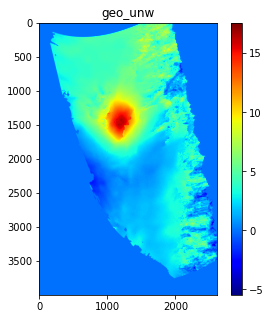

In [8]:
os.chdir(r'D:\读取GAMMA结果')

# data = read_gamma('20160109-20160214.diff.int.sm.unw', 428, 1171, 'float32')
# plot_data(data, cmap='jet', title='unw')

data = read_gamma('20160109-20160214.diff.utm.unw', 2612, 4000, 'float32')
disp = -data * 5.6 / (4 * np.pi)
plot_data(disp, cmap='jet', title='geo_unw')

print('max displacement(cm): ', np.max(disp))
print('min displacement(cm): ', np.min(disp))

## read coherence

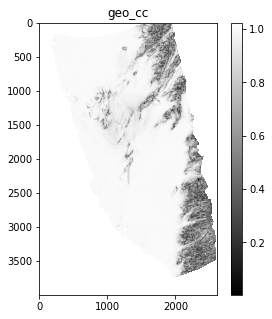

In [10]:
# data = read_gamma('20160109-20160214.diff.sm.cc', 428, 1171, 'float32')
# plot_data(data, cmap='gray', title='cc')

data = read_gamma('20160109-20160214.utm.cc', 2612, 4000, 'float32')
data[data==0] = np.nan
plot_data(data, cmap='gray', title='geo_cc')

## read interferogram

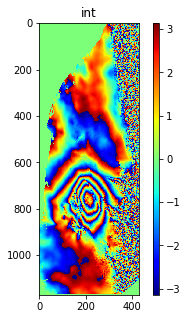

In [23]:
data = read_gamma('20160109-20160214.diff.int.sm', 428, 1171, 'complex64')
plot_data(np.angle(data), cmap='jet', title='int')

## wrap data

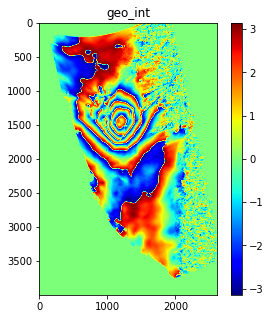

In [10]:
data = read_gamma('20160109-20160214.diff.utm.unw', 2612, 4000, 'float32')
wrapped_data = wrap_data(data, wrap_range=[-np.pi, np.pi])
plot_data(wrapped_data, cmap='jet', title='geo_int')

## mask data using coherence

C:\thorly\Softwares\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in remainder


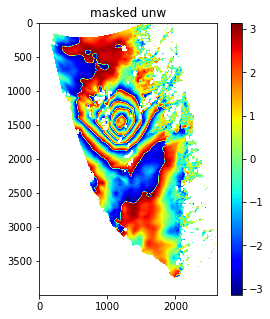

In [12]:
masked_data = mask_data('20160109-20160214.diff.utm.unw', 2612, 4000,
                        'float32', '20160109-20160214.utm.cc', 0.3)
wrapped_data = wrap_data(masked_data, wrap_range=[-np.pi, np.pi])
plot_data(wrapped_data, cmap='jet', title='masked unw')

## data2xyz

In [15]:
data2xyz(wrapped_data, 'dem_seg.par', out_file='ifg.txt', data_type='float32')

## data2kmz

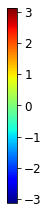

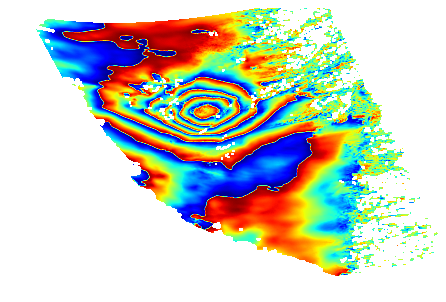

In [33]:
lon_lat = [22.25673796, 23.3681578, 120.0711309, 120.796888056]
lon_lat = get_lon_lat('dem_seg.par')

write_kmz(lon_lat, wrapped_data, r'D:\读取GAMMA结果\wrapped_data1', cmap='jet')